# Training dataset for localization task

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
from PIL import Image, ImageDraw
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

Assuming we have already executed file "3_Preprocess_SVHN.ipynb", we can just load the generated files.

In [8]:
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

pickle_name = 'SVHN_data/temp_train.pickle'

with open(pickle_name, 'rb') as f:
    train_data = pickle.load(f)
    
pickle_name = 'SVHN_data/temp_test.pickle'

with open(pickle_name, 'rb') as f:
    test_data = pickle.load(f)
    
pickle_name = 'SVHN_data/temp_extra.pickle'

with open(pickle_name, 'rb') as f:
    extra_data = pickle.load(f)
    
print('Training size:', len(train_data))
print('Testing size:',len(test_data))
print('Extra images:',len(extra_data))

Training size: 33402
Testing size: 13068
Extra images: 202353


In [3]:
# Defining our input size
IMG_WIDTH = 64.0   # Input image width
IMG_HEIGHT = 48.0  # Input image height

## CIFAR

Using CIFAR images as samples without numbers

In [4]:
import PIL.Image as Image
filenames = [os.path.join('CIFAR_data/cifar-10-batches-py/', 'data_batch_%d' % i)for i in xrange(1, 6)]
first = True
for pickle_name in filenames:
    with open(pickle_name, 'rb') as f:
        dict_cifar10 = pickle.load(f)
        temp = dict_cifar10['data']
        if(first):
            cifar_data = temp
            first = False
        else:
            cifar_data = np.concatenate((cifar_data,temp),axis=0)

cifar_data = np.reshape(cifar_data,(-1,3,32,32))
cifar_data = np.swapaxes(cifar_data, 1, 2)
cifar_data = np.swapaxes(cifar_data, 2, 3)
print(cifar_data.shape)

def generate_dataset_CIFAR(data):
    dataset = np.ndarray([data.shape[0],int(IMG_HEIGHT),int(IMG_WIDTH),3], dtype=np.int8)
    labels = np.ones([data.shape[0],5], dtype=np.int8) * 0

    for i in np.arange(data.shape[0]):
        im = Image.fromarray(data[i])
        temp_label = [0] * 5

        im = im.resize([int(IMG_WIDTH),int(IMG_HEIGHT)], Image.ANTIALIAS)
        #im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        #mean = np.mean(im, dtype='float32')
        #im = (im - mean)
        dataset[i,:,:,:] = im
        labels[i,:] = temp_label
        
    return dataset, labels

cifar_data, cifar_data_labels = generate_dataset_CIFAR(cifar_data)
print(cifar_data.shape, cifar_data_labels.shape)
print(cifar_data.dtype, cifar_data_labels.dtype)

(50000, 32, 32, 3)
(50000, 48, 64, 3) (50000, 5)
int8 int8


## Processing SVHN data

In [5]:
# This function returns the coordinates of the bounding box surrounding all the numbers
def get_bbox_coordinates(boxes,original_width, original_height):
    top = np.ndarray([len(boxes)], dtype='float32')
    left = np.ndarray([len(boxes)], dtype='float32')
    height = np.ndarray([len(boxes)], dtype='float32')
    width = np.ndarray([len(boxes)], dtype='float32')
    for i in range(len(boxes)):
        top[i] = boxes[i]['top']
        left[i] = boxes[i]['left']
        height[i] = boxes[i]['height']
        width[i] = boxes[i]['width']

    im_top = np.amin(top)
    im_left = np.amin(left)
    im_height = np.amax(top) + height[np.argmax(top)] - im_top
    im_width = np.amax(left) + width[np.argmax(left)] - im_left        

    # Expanding by 0%
    expand = 0.0
    im_bottom = np.amin([np.ceil(im_top + (1.0+expand) * im_height), original_height])
    im_right = np.amin([np.ceil(im_left + (1.0+expand) * im_width), original_width])
    im_top = np.amax([np.floor(im_top - expand * im_height), 0])
    im_left = np.amax([np.floor(im_left - expand * im_width), 0])

    return im_top, im_left, im_bottom, im_right

 - Using only images with less than 4 digits. (Not many with more than 4)
 - Using only those images larger than our desired input size, in order to have good resolution

In [10]:
idx_ok = []
digits_count = [0,0,0]
# The original datasets where generated using all the training and testing samples. For simplicity, we 
# will run the following code using only 1000 samples

#for i in np.arange(len(train_data)):
for i in np.arange(1000):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    width, height = im.size
    boxes = train_data[i]['boxes']
    num_digits = len(boxes)
    if num_digits<4:
        if width >= IMG_WIDTH and height >= IMG_HEIGHT: 
            digits_count[num_digits-1] = digits_count[num_digits-1] + 1;
            idx_ok.append(i)

# Printing number of samples with 1, 2 and 3 digits            
dataset_train = [ train_data[i] for i in idx_ok]
print(digits_count)

idx_ok = []
digits_count = [0,0,0]
#for i in np.arange(len(test_data)):
for i in np.arange(1000):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    width, height = im.size
    boxes = test_data[i]['boxes']
    num_digits = len(boxes)
    if num_digits<4:
        if width >= IMG_WIDTH and height >= IMG_HEIGHT:   
            digits_count[num_digits-1] = digits_count[num_digits-1] + 1;
            idx_ok.append(i)

dataset_test = [ test_data[i] for i in idx_ok]

# Printing number of samples with 1, 2 and 3 digits
print(digits_count)

print(len(dataset_train))
print(len(dataset_test))

[62, 265, 146]
[115, 385, 104]
473
604


(445, 181)


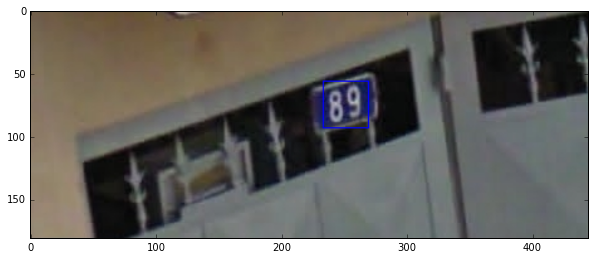

In [12]:
# Taking one picture as an example
sample_image = 10
filename = dataset_train[sample_image]['filename']
fullname = os.path.join(train_folders, filename)
im = Image.open(fullname)

draw = ImageDraw.Draw(im)

boxes = dataset_train[sample_image]['boxes']
top, left, buttom, right = get_bbox_coordinates(boxes,im.size[0],im.size[1])

# Plotting expanded bounding box in blue
draw.rectangle([left, top, right, buttom], fill=None, outline=(0,0,255))

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(im)
plt.grid(False)

print(im.size)

### Generating training dataset

We augment the data by sliding a window trough the original image while making sure that the number is still visible within the this window. If possible, we scale the original image to generate even more samples.

In [13]:
def generate_regression_dataset(data, folder, stepx, stepy):
    init = True
    for i in np.arange(len(data)):
        # Prints progress
        if i%1000 == 1:
            print(i, '-', dataset.shape)

        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        
        original_width, original_height = im.size
        top, left, buttom, right = get_bbox_coordinates(boxes, original_width, original_height)
        width_bbox = right-left
        height_bbox = buttom-top
        # Making sure that Bbox can be contained by the input size
        if width_bbox > IMG_WIDTH or height_bbox > IMG_HEIGHT:
            # If the number is larger than our input size, we scale the original image appropriately.
            proportion = max(width_bbox/IMG_WIDTH, height_bbox/IMG_HEIGHT)
            new_width = int(np.ceil(original_width / proportion))
            new_height = int(np.ceil(original_height / proportion))
            im = im.resize([new_width,new_height], Image.ANTIALIAS)
            # We also scale the Bbox coordinates
            top, left, buttom, right = np.divide([top, left, buttom, right],proportion)
            top, left = np.floor([top, left])
            buttom, right = np.ceil([buttom, right])
            original_width, original_height = im.size
        
        # Get resizing proportions (only one additional scale if possible)
        prop = min(original_width/IMG_WIDTH, original_height/IMG_HEIGHT)
        scale = min(2,prop) # Max_scale would be 2
        if scale > 1.2:     # Min_scale would be 1.2
            scales = [1.0, scale]
        else:
            scales = [1.0]
            
        
        for scale in scales:
            # If possible, we scale the original image to have samples with small bounding boxes.
            if scale != 1.0:               
                new_width = int(np.ceil(original_width / scale))
                new_height = int(np.ceil(original_height / scale))
                im = im.resize([new_width,new_height], Image.ANTIALIAS)
                top, left, buttom, right = np.divide([top, left, buttom, right],scale)
                top, left = np.floor([top, left])
                buttom, right = np.ceil([buttom, right])
                original_width, original_height = im.size

            # We identify the region of the image where we can slide a window while still having the number visible
            min_x = max(0,right - IMG_WIDTH)
            min_y = max(0,buttom - IMG_HEIGHT)

            max_x = min(original_width-IMG_WIDTH, left)
            max_y = min(original_height-IMG_HEIGHT, top)

            x_range = np.arange(min_x,max_x,stepx)
            y_range = np.arange(min_y,max_y,stepy)
            
            if x_range.size == 0:
                x_range = [min_x]
            elif x_range[-1] < max_x-stepx/2:
                x_range = np.append(x_range,max_x)
            
            if y_range.size == 0:
                y_range = [min_y]
            elif y_range[-1] < max_y-stepy/2:
                y_range = np.append(y_range,max_y)

            # Sliding a window and cropping according to the x and y steps (stride)
            for x in x_range:
                for y in y_range:
                    patch = np.array(im.crop((int(x), int(y), int(x+IMG_WIDTH), int(y+IMG_HEIGHT))),np.int8)
                    patch = np.expand_dims(np.array(patch), axis=0)
                    
                    patch_top = np.int8(max(0,top - y))
                    patch_left = np.int8(max(0,left - x))
                    patch_buttom = np.int8(buttom - y)
                    patch_right = np.int8(right - x)

                    patch_label = np.int8(np.expand_dims([1, patch_top, patch_left, patch_buttom, patch_right],axis=0))

                    if patch_top<0 or patch_left<0 or patch_buttom<0 or patch_right<0:
                        print('error in image:', i)
                        print(patch_label)
                    if init==True:
                        init = False
                        dataset = patch
                        labels = patch_label
                    else:
                        dataset = np.concatenate((dataset, patch), axis=0)
                        labels = np.concatenate((labels, patch_label), axis=0)                      

    return dataset, labels

stepx = 8
stepy = 4

Generating Training and Testing samples. This may take a while given the number of images... (Right now the code is only using a small subset of samples for visualization purposes)

In [14]:
train_dataset, train_labels = generate_regression_dataset(dataset_train[:100], train_folders, stepx, stepy)
print(train_dataset.shape, train_labels.shape)

1 - (9, 48, 64, 3)
(1104, 48, 64, 3) (1104, 5)


In [15]:
test_dataset, test_labels = generate_regression_dataset(dataset_test[:100], test_folders, stepx, stepy)
print(test_dataset.shape, test_labels.shape)

1 - (5, 48, 64, 3)
(3178, 48, 64, 3) (3178, 5)


Plotting some of the generated images. It can be seen how the location and scale of the number changes.

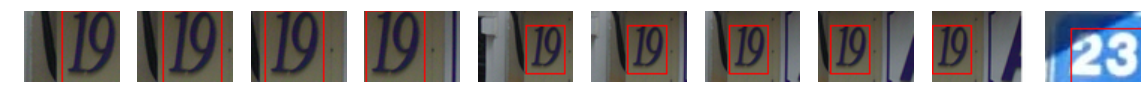

In [16]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i in range(10):
    im = Image.fromarray(np.uint8(train_dataset[i,:,:,:]))
    
    draw = ImageDraw.Draw(im)
    left = train_labels[i,2]
    right = train_labels[i,4]
    top = train_labels[i,1]
    buttom = train_labels[i,3]
    draw.rectangle([left, top, right, buttom], fill=None, outline=(255,0,0))
    
    ax[i].axis('off')
    ax[i].imshow(im)

## Shuffling and splitting the data

Adding the CIFAR samples to the datasets

In [17]:
import random
random.seed()

test_valid_data = np.concatenate((test_dataset, cifar_data[:3000,:]), axis=0)
test_valid_data_label = np.concatenate((test_labels, cifar_data_labels[:3000,:]), axis=0)

num_images = test_valid_data.shape[0]
index = np.arange(num_images)

# Shuffling the data
random.shuffle(index)

valid_dataset = test_valid_data[index[:num_images//2]]
valid_labels = test_valid_data_label[index[:num_images//2]]
test_dataset = test_valid_data[index[num_images//2:]]
test_labels = test_valid_data_label[index[num_images//2:]]

print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(3089, 48, 64, 3) (3089, 5)
(3089, 48, 64, 3) (3089, 5)


In [18]:
all_data = np.concatenate((train_dataset, cifar_data[3000:,:]), axis=0)
all_data_label = np.concatenate((train_labels, cifar_data_labels[3000:,:]), axis=0)

num_images = all_data.shape[0]
index = np.arange(num_images)

# Shuffling the data
random.shuffle(index)

train_dataset_final = all_data[index]
train_labels_final = all_data_label[index]

print(train_dataset_final.shape, train_labels_final.shape)

(48104, 48, 64, 3) (48104, 5)


## Saving the data

Testing and Validation are stored in a Pickle file

In [19]:
# Name of the file where validation and testing data will be stores
pickle_file = 'SVHN_data/Regression_3Ch_Test.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 84317137


## Saving binaries

In [29]:
# We will store the images as 1D-arrays and we will concatenate the labels at the beginning of the arrays

name = 'TrainRegression'
# Training dataset
temp = np.reshape(train_dataset_final,(train_dataset_final.shape[0],train_dataset_final.shape[1]*train_dataset_final.shape[2]*train_dataset_final.shape[3]))
temp = np.concatenate((train_labels_final,temp), axis=1)

# Splitting the data into different files in order to gain some parallelism when loading samples
num_files = 3
number_per_file = temp.shape[0] // num_files
for i in range(num_files):
    if i==num_files-1:
        segment = temp[i*number_per_file:,:]
    else:
        segment = temp[i*number_per_file:(i+1)*number_per_file,:]
    
    filename = 'SVHN_data/' + name + '_' + str(i+1) + '.bin'
    contents = segment.tobytes()
    open(filename, "wb").write(contents)

del temp
print('Train OK')

Train OK
